In [36]:
# SEL 1 — Install & import
!pip install -q scikit-learn joblib seaborn matplotlib pandas numpy tqdm

import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
import joblib

# aesthetics
sns.set(style="whitegrid", rc={'figure.figsize': (10,6)})


In [24]:
# SEL 2 Load data

LOCAL_FILE = 'AmesHousing.csv'
URL = 'https://raw.githubusercontent.com/selva86/datasets/master/AmesHousing.csv'

df = pd.read_csv(LOCAL_FILE)

print('Data shape:', df.shape)
df.head()

Data shape: (2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [37]:
# SEL 3 — Info kolom, tipe, missing
info = pd.DataFrame({
    'column': df.columns,
    'dtype': df.dtypes.astype(str),
    'missing_count': df.isna().sum().values,
    'missing_pct': (df.isna().sum().values / len(df) * 100).round(2)
}).sort_values('missing_pct', ascending=False)

# tampilkan top 40 kolom ber-missing
info.head(40)


,column,dtype,missing_count,missing_pct
Pool QC,Pool QC,object,2917,99.56
Misc Feature,Misc Feature,object,2824,96.38
Alley,Alley,object,2732,93.24
Fence,Fence,object,2358,80.48
Mas Vnr Type,Mas Vnr Type,object,1775,60.58
Fireplace Qu,Fireplace Qu,object,1422,48.53
Lot Frontage,Lot Frontage,float64,490,16.72
Garage Finish,Garage Finish,object,159,5.43
Garage Yr Blt,Garage Yr Blt,float64,159,5.43
Garage Qual,Garage Qual,object,159,5.43


,count,mean,std,min,25%,50%,75%,max
SalePrice,2930.0,180796.060068,79886.692357,12789.0,129500.0,160000.0,213500.0,755000.0


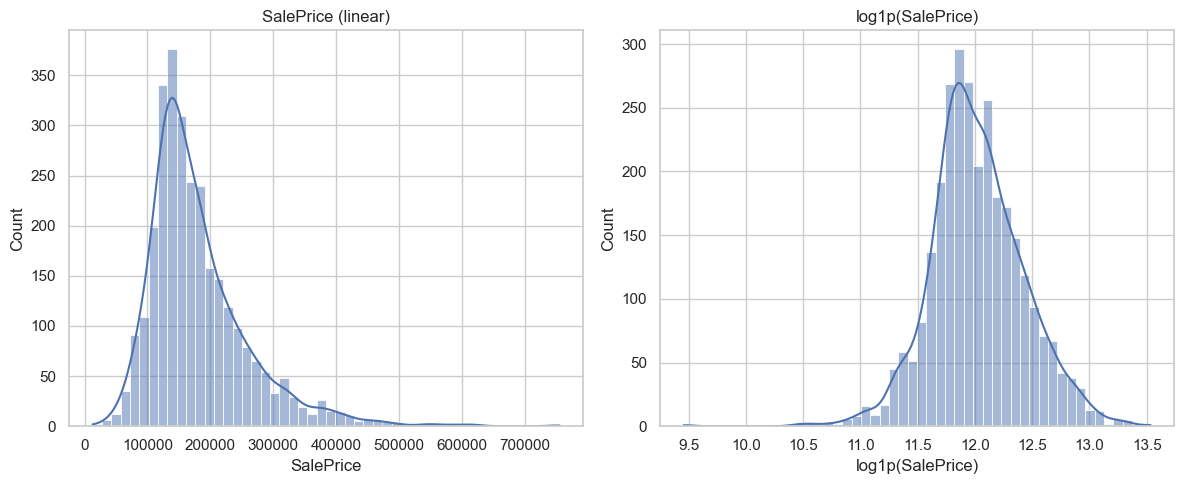

In [38]:
# SEL 4 — Statistik dasar dan distribusi SalePrice
display(df['SalePrice'].describe().to_frame().T)

# Plot distribusi SalePrice (linier) dan log
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['SalePrice'], bins=50, kde=True)
plt.title('SalePrice (linear)')
plt.xlabel('SalePrice')

plt.subplot(1,2,2)
sns.histplot(np.log1p(df['SalePrice']), bins=50, kde=True)
plt.title('log1p(SalePrice)')
plt.xlabel('log1p(SalePrice)')

plt.tight_layout()
plt.show()


In [41]:
# SEL 5 — Feature engineering ringan (versi aman dari error KeyError)

df = df.copy()

# --- Buat TotalSF jika semua kolom pendukung tersedia ---
cols_sf = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']
if all(col in df.columns for col in cols_sf):
    df['TotalSF'] = df['TotalBsmtSF'].fillna(0) + df['1stFlrSF'].fillna(0) + df['2ndFlrSF'].fillna(0)
else:
    print("[Info] Kolom untuk TotalSF tidak lengkap, lewati pembuatan fitur TotalSF.")

# --- Buat HouseAge jika kolom pendukung tersedia ---
if 'YrSold' in df.columns and 'YearBuilt' in df.columns:
    df['HouseAge'] = df['YrSold'].fillna(df['YrSold'].mode()[0]) - df['YearBuilt'].fillna(df['YearBuilt'].median())
else:
    print("[Info] Kolom untuk HouseAge tidak lengkap, lewati pembuatan fitur HouseAge.")

# --- Buat log transformasi target ---
if 'SalePrice' in df.columns:
    df['SalePrice_Log'] = np.log1p(df['SalePrice'])
else:
    raise KeyError("Kolom 'SalePrice' tidak ditemukan di dataset!")

# --- Ringkasan fitur baru jika ada ---
new_cols = [c for c in ['TotalSF','HouseAge','SalePrice','SalePrice_Log'] if c in df.columns]
display(df[new_cols].describe().T)


[Info] Kolom untuk TotalSF tidak lengkap, lewati pembuatan fitur TotalSF.
[Info] Kolom untuk HouseAge tidak lengkap, lewati pembuatan fitur HouseAge.


,count,mean,std,min,25%,50%,75%,max
SalePrice,2930.0,180796.060068,79886.692357,12789.000000,129500.000000,160000.000000,213500.000000,755000.000000
SalePrice_Log,2930.0,12.020975,0.407584,9.456419,11.771444,11.982935,12.271397,13.534474


In [42]:
# SEL 6 — Pilih fitur: ambil top-N numeric korelasi terhadap SalePrice_Log + selected categories
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# hindari Id dan target
num_cols = [c for c in num_cols if c not in ('Id','SalePrice','SalePrice_Log')]

# korelasi absolut terhadap SalePrice_Log
corrs = df[num_cols + ['SalePrice_Log']].corr()['SalePrice_Log'].abs().sort_values(ascending=False)
# ambil top 20 numeric (kecuali SalePrice_Log sendiri)
top_numeric = [c for c in corrs.index if c != 'SalePrice_Log'][:20]

# pilih beberapa kategori yang sering berguna jika ada
cat_candidates = ['Neighborhood','ExterQual','BsmtQual','KitchenQual','GarageType']
top_cat = [c for c in cat_candidates if c in df.columns]

print("Top numeric selected:", top_numeric)
print("Categorical selected:", top_cat)

# final feature list
features = top_numeric + top_cat
len(features), features[:10]


Top numeric selected: ['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area', 'Total Bsmt SF', 'Year Built', '1st Flr SF', 'Year Remod/Add', 'Garage Yr Blt', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Mas Vnr Area', 'BsmtFin SF 1', 'Lot Frontage', 'Wood Deck SF', 'Open Porch SF', 'Half Bath', 'Bsmt Full Bath', '2nd Flr SF']
Categorical selected: ['Neighborhood']


(21,
 ['Overall Qual',
  'Gr Liv Area',
  'Garage Cars',
  'Garage Area',
  'Total Bsmt SF',
  'Year Built',
  '1st Flr SF',
  'Year Remod/Add',
  'Garage Yr Blt',
  'Full Bath'])

In [43]:
# SEL 7 — Preprocessing pipeline
X = df[features].copy()
y = df['SalePrice_Log'].copy()  # gunakan log target untuk model baseline

# Identify numeric & categorical in chosen features
numeric_features = [c for c in top_numeric if c in X.columns]
categorical_features = [c for c in top_cat if c in X.columns]

# imputers + encoders
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categorical: OHE if low-cardinality, else ordinal
low_card = [c for c in categorical_features if df[c].nunique() <= 10]
high_card = [c for c in categorical_features if c not in low_card]

from sklearn.pipeline import Pipeline as SKPipeline
cat_transformers = []
transformers = []
if numeric_features:
    transformers.append(('num', numeric_transformer, numeric_features))
if low_card:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    transformers.append(('ohe', SKPipeline([('imputer', SimpleImputer(strategy='constant', fill_value='NA')), ('ohe', ohe)]), low_card))
if high_card:
    ord_enc = OrdinalEncoder()
    transformers.append(('ord', SKPipeline([('imputer', SimpleImputer(strategy='constant', fill_value='NA')), ('ord', ord_enc)]), high_card))

preprocessor = ColumnTransformer(transformers=transformers, remainder='drop', sparse_threshold=0)
preprocessor


ColumnTransformer(sparse_threshold=0,
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Overall Qual', 'Gr Liv Area', 'Garage Cars',
                                  'Garage Area', 'Total Bsmt SF', 'Year Built',
                                  '1st Flr SF', 'Year Remod/Add',
                                  'Garage Yr Blt', 'Full Bath', 'TotRms AbvGrd',
                                  'Fireplaces', 'Mas Vnr Area', 'BsmtFin SF 1',
                                  'Lot Frontage', 'Wood Deck SF',
                                  'Open Porch SF', 'Half Bath',
                                  'Bsmt Full Bath', '2nd Flr SF']),
                                ('ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('ord', OrdinalEncoder())]),
                                 ['Neighborhood'])])

In [44]:
# SEL 8 — Train-test split (stratify not needed karena regresi)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Build pipelines for two models
rf_pipeline = Pipeline(steps=[
    ('preproc', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1))
])

ridge_pipeline = Pipeline(steps=[
    ('preproc', preprocessor),
    ('ridge', Ridge(alpha=1.0))
])

# Fit
print("Fitting RandomForest...")
rf_pipeline.fit(X_train, y_train)
print("Fitting Ridge...")
ridge_pipeline.fit(X_train, y_train)


Fitting RandomForest...
Fitting Ridge...


Pipeline(steps=[('preproc',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Overall Qual',
                                                   'Gr Liv Area', 'Garage Cars',
                                                   'Garage Area',
                                                   'Total Bsmt SF',
                                                   'Year Built', '1st Flr SF',
                                                   'Year Remod/Add',
                                                   'Garage Yr Blt', 'Full Bath',
                                                   'TotRms AbvGrd',
                                                   'Fireplaces', 'Mas Vnr Area',
                                                   'BsmtFin SF 1',
                                                   'Lot Frontage',
                                                   'Wood Deck SF',
                                                   'Open Porch SF', 'Half Bath',
                                                   'Bsmt Full Bath',
                                                   '2nd Flr SF']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('ord',
                                                                   OrdinalEncoder())]),
                                                  ['Neighborhood'])])),
                ('ridge', Ridge())])

RandomForest → RMSE: 28477.74, R2: 0.8988


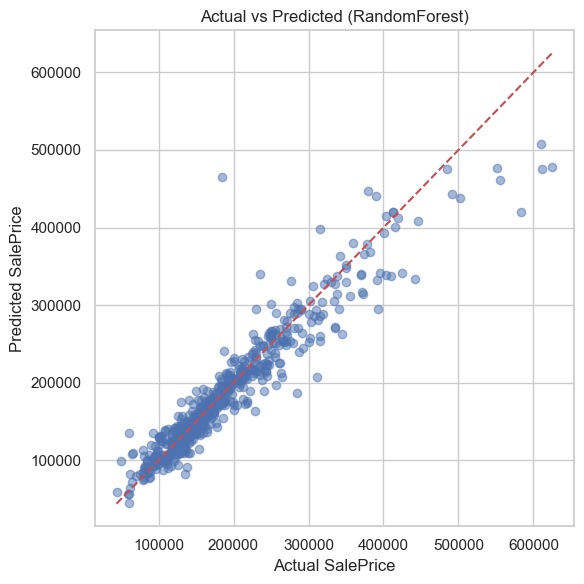

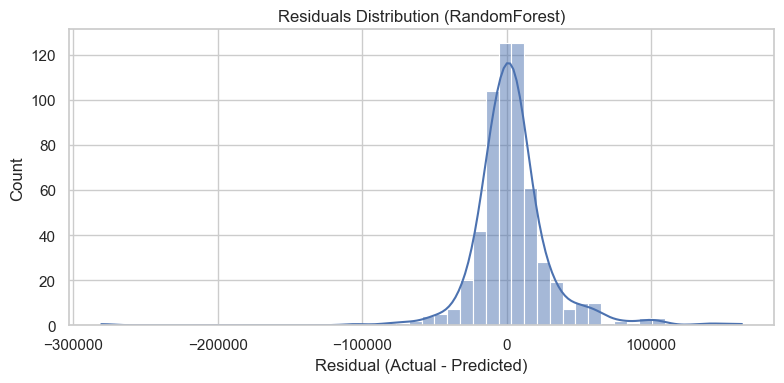

Ridge → RMSE: 37200.80, R2: 0.8274


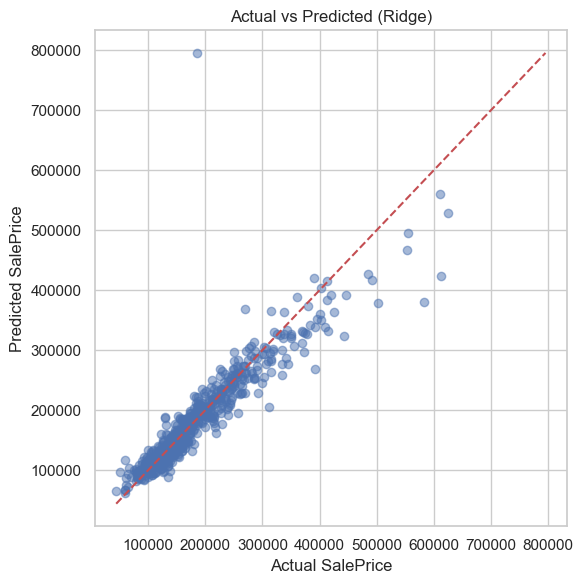

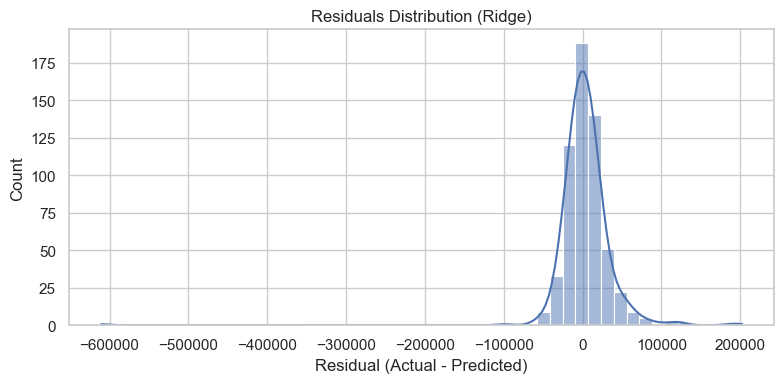

In [45]:
# SEL 9 — Predictions & metrics (kembalikan ke skala asli untuk interpretasi)
def eval_and_plot(pipe, name):
    y_pred_log = pipe.predict(X_test)
    # ke skala asli
    y_test_orig = np.expm1(y_test)
    y_pred_orig = np.expm1(y_pred_log)
    mse = mean_squared_error(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_orig, y_pred_orig)
    print(f"{name} → RMSE: {rmse:.2f}, R2: {r2:.4f}")

    # Actual vs Predicted
    plt.figure(figsize=(6,6))
    plt.scatter(y_test_orig, y_pred_orig, alpha=0.5)
    mi = min(y_test_orig.min(), y_pred_orig.min()); ma = max(y_test_orig.max(), y_pred_orig.max())
    plt.plot([mi, ma], [mi, ma], '--', color='r')
    plt.xlabel('Actual SalePrice'); plt.ylabel('Predicted SalePrice')
    plt.title(f'Actual vs Predicted ({name})')
    plt.tight_layout()
    plt.show()

    # Residuals distribution
    res = y_test_orig - y_pred_orig
    plt.figure(figsize=(8,4))
    sns.histplot(res, bins=50, kde=True)
    plt.title(f'Residuals Distribution ({name})')
    plt.xlabel('Residual (Actual - Predicted)')
    plt.tight_layout()
    plt.show()

# evaluate
eval_and_plot(rf_pipeline, 'RandomForest')
eval_and_plot(ridge_pipeline, 'Ridge')


In [46]:
# SEL 10 — Ekstrak nama fitur setelah preprocessing (usaha best-effort)
def get_feature_names(ct, input_cols):
    names = []
    for name, trans, cols in ct.transformers_:
        if name == 'remainder' and trans == 'drop':
            continue
        if hasattr(trans, 'named_steps') and 'ohe' in trans.named_steps:
            ohe = trans.named_steps['ohe']
            try:
                fn = ohe.get_feature_names_out(cols)
            except:
                fn = [f"{c}_{i}" for i,c in enumerate(cols)]
            names.extend(fn.tolist())
        elif hasattr(trans, 'named_steps') and 'ord' in trans.named_steps:
            names.extend(cols)
        elif name == 'num' or (hasattr(trans,'named_steps') and 'imputer' in trans.named_steps and 'scaler' in trans.named_steps):
            names.extend(cols)
        else:
            names.extend(cols)
    return names

# attempt to get feature names
ct = rf_pipeline.named_steps['preproc']
feature_names = get_feature_names(ct, X_train.columns.tolist())
len(feature_names), feature_names[:40]


(21,
 ['Overall Qual',
  'Gr Liv Area',
  'Garage Cars',
  'Garage Area',
  'Total Bsmt SF',
  'Year Built',
  '1st Flr SF',
  'Year Remod/Add',
  'Garage Yr Blt',
  'Full Bath',
  'TotRms AbvGrd',
  'Fireplaces',
  'Mas Vnr Area',
  'BsmtFin SF 1',
  'Lot Frontage',
  'Wood Deck SF',
  'Open Porch SF',
  'Half Bath',
  'Bsmt Full Bath',
  '2nd Flr SF',
  'Neighborhood'])

Overall Qual      0.602614
Gr Liv Area       0.092843
Garage Cars       0.049095
Garage Area       0.044621
Total Bsmt SF     0.036974
1st Flr SF        0.036694
BsmtFin SF 1      0.023466
Year Built        0.022409
Year Remod/Add    0.018790
Lot Frontage      0.011320
2nd Flr SF        0.008531
Neighborhood      0.008033
Garage Yr Blt     0.008002
Open Porch SF     0.007103
Fireplaces        0.005852
Full Bath         0.005615
TotRms AbvGrd     0.004900
Wood Deck SF      0.004735
Mas Vnr Area      0.004437
Bsmt Full Bath    0.002541
dtype: float64

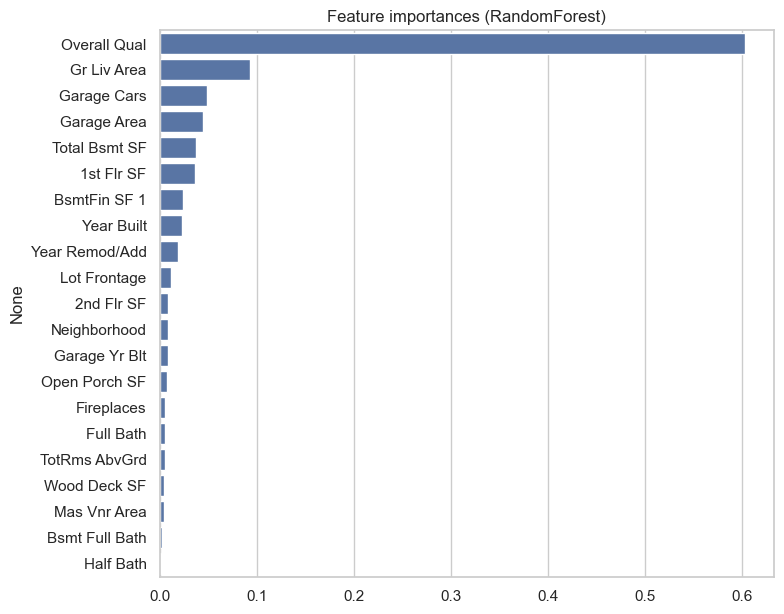

Computing permutation importance (this may take some time)...


Overall Qual      0.421885
Gr Liv Area       0.112829
Total Bsmt SF     0.021759
Year Remod/Add    0.016157
Garage Area       0.015406
BsmtFin SF 1      0.014023
1st Flr SF        0.011542
Garage Cars       0.011534
Year Built        0.008964
Neighborhood      0.004834
Lot Frontage      0.004444
Fireplaces        0.003908
Open Porch SF     0.002262
Wood Deck SF      0.001347
2nd Flr SF        0.001321
Bsmt Full Bath    0.001236
Garage Yr Blt     0.001206
TotRms AbvGrd     0.000893
Half Bath         0.000349
Full Bath         0.000251
dtype: float64

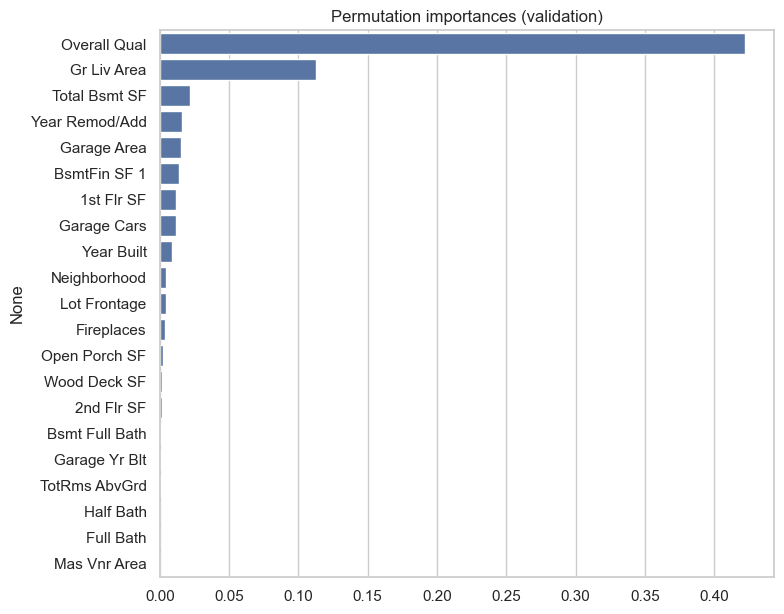

In [47]:
# SEL 11 — Feature importances dari RF (jika tersedia)
rf = rf_pipeline.named_steps['rf']
if hasattr(rf, 'feature_importances_'):
    importances = rf.feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(40)
    display(fi.head(20))
    # plot
    plt.figure(figsize=(8, min(12, 0.3*len(fi))))
    sns.barplot(x=fi.values, y=fi.index)
    plt.title('Feature importances (RandomForest)')
    plt.tight_layout()
    plt.show()
else:
    print("RandomForest feature_importances_ tidak tersedia.")

# Permutation importance (lebih andal)
print("Computing permutation importance (this may take some time)...")
perm = permutation_importance(rf_pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_idx = perm.importances_mean.argsort()[::-1]
perm_names = np.array(feature_names)[perm_idx][:30]
perm_means = perm.importances_mean[perm_idx][:30]
perm_df = pd.Series(perm_means, index=perm_names)
display(perm_df.head(20))

plt.figure(figsize=(8, min(12, 0.3*len(perm_df))))
sns.barplot(x=perm_df.values, y=perm_df.index)
plt.title('Permutation importances (validation)')
plt.tight_layout()
plt.show()


In [49]:
# SEL 12 — Simpan outputs ke folder ames_outputs
outdir = Path('ames_outputs')
outdir.mkdir(parents=True, exist_ok=True)

# Save models
joblib.dump(rf_pipeline, outdir/'rf_pipeline.joblib')
joblib.dump(ridge_pipeline, outdir/'ridge_pipeline.joblib')

# Save top feature importances csv (if computed)
if 'fi' in locals():
    fi.to_csv(outdir/'feature_importances_rf_top40.csv')

# Save permutation importance
perm_df.to_csv(outdir/'permutation_importances_val.csv')

# Simple metrics summary
def metrics_summary(pipe, name):
    y_pred_log = pipe.predict(X_test)
    y_test_orig = np.expm1(y_test)
    y_pred_orig = np.expm1(y_pred_log)
    return {
        'model': name,
        'rmse': float(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))),
        'r2': float(r2_score(y_test_orig, y_pred_orig))
    }

summary = [metrics_summary(rf_pipeline, 'RandomForest'), metrics_summary(ridge_pipeline, 'Ridge')]
pd.DataFrame(summary).to_csv(outdir/'regression_summary.csv', index=False)

print("Saved models and CSV summaries to", outdir.resolve())
!ls -lah ames_outputs | sed -n '1,200p'


Saved models and CSV summaries to C:\Users\LAPTOP\Desktop\BELAJAR PYTHON\ames_outputs


'ls' is not recognized as an internal or external command,
operable program or batch file.


              precision    recall  f1-score   support

        High       0.90      0.89      0.90       194
         Low       0.88      0.89      0.88       196
      Medium       0.78      0.78      0.78       196

    accuracy                           0.85       586
   macro avg       0.85      0.85      0.85       586
weighted avg       0.85      0.85      0.85       586



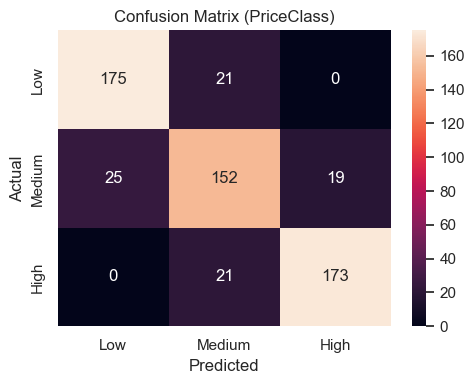

In [50]:
# SEL 13 — Buat kelas harga (Low / Medium / High) berdasarkan quantile lalu latih classifier sederhana
# Opsional: jalankan jika ingin analisis klasifikasi
run_classification = True

if run_classification:
    df_clf = df.copy()
    df_clf['PriceClass'] = pd.qcut(df_clf['SalePrice'], q=3, labels=['Low','Medium','High'])
    y_clf = df_clf['PriceClass']
    X_clf = df_clf[features].copy()
    # Apply same preprocessing (fit on X_train earlier) - to simplify, we will build a new pipeline
    Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf)
    
    # Simple pipeline: preprocessor + RandomForestClassifier
    from sklearn.ensemble import RandomForestClassifier
    clf_pipeline = Pipeline(steps=[('preproc', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])
    clf_pipeline.fit(Xc_train, yc_train)
    yp = clf_pipeline.predict(Xc_test)
    print(classification_report(yc_test, yp))
    cm = confusion_matrix(yc_test, yp, labels=['Low','Medium','High'])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Low','Medium','High'], yticklabels=['Low','Medium','High'])
    plt.title('Confusion Matrix (PriceClass)')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    # Save classifier model
    joblib.dump(clf_pipeline, outdir/'rf_classifier_priceclass.joblib')
